# Searching for Multiple Origins of Replication in *Methanococcus jannaschii*

*Santiago Wilders Azara — February 2026*

---

Unlike bacteria, which typically have a single replication origin (oriC), many archaea 
have been shown to harbor multiple oriCs. Lundgren et al. (2004) demonstrated this 
experimentally in *Sulfolobus solfataricus*, and since then multiple oriCs have been 
identified across many archaeal genomes.

*Methanococcus jannaschii* is considered the workhorse of archaea genomics, but
its oriC(s) still remain unidentified. 

This remains an open problem. The goal here is not to arrive at a 
validated answer, but to apply and stress-test the tools seen in  *Bioinformatics Algorithms: An Active Learning Approach*,
to a more complex biological scenario. Tools include skew minimization, frequent k-mer analysis, and clump finding.

## 1. Utility Functions

In [1]:
import sys
sys.path.append("../../")

from bio_utils import (
    reverse_complement,
    neighborhood,
    hamming_distance,
    skew_list,
    skew_min,
    count_pattern_occurrences,
    frequent_patterns_with_mismatches,
    find_clumps,
    clean_clump_noise,
    highlight_sequence_html,
    plot_gc_skew
)

#### bio_utils provides the following functions:

- **reverse_complement** - returns the reverse complement of a DNA string.
- **neighborhood** - generates all k-mers within Hamming distance d of a pattern.
- **skew_list** - computes the cumulative G-C skew along the sequence.
- **skew_min** - returns positions where the skew reaches its global minimum (oriC candidates).
- **count_pattern_occurrences** - counts exact occurrences of a pattern, overlaps included.
- **frequent_patterns_with_mismatches** - finds the most frequent k-mers allowing mismatches, grouped by reverse complement pair.
- **find_clumps** - finds k-mers forming (k, L, t)-clumps, with optional mismatch and RC support.
- **clean_clump_noise** - filters clump results keeping the best representative based on hamming distance and exact appearences.
- **highlight_sequence_html** - prints a DNA sequence with pattern highlights as colored HTML.
- **plot_gc_skew** - plots the G-C skew along a DNA sequence and marks the minimum position(s).

## 2. Data

The genome sequence (.fna file) was downloaded directly from the [NCBI Datasets portal](https://www.ncbi.nlm.nih.gov/datasets/taxonomy/2190/) and to read it we use BioPython's SeqIO module.

In [2]:
from Bio import SeqIO

ruta_fna = "GCF_000091665.1_ASM9166v1_genomic.fna"
data_iterator = SeqIO.parse(ruta_fna, "fasta")

for register in data_iterator:
    print(register)
    print(f"Length: {len(register.seq)} bp")
    print("-" * 100)

ID: NC_000909.1
Name: NC_000909.1
Description: NC_000909.1 Methanocaldococcus jannaschii DSM 2661, complete sequence
Number of features: 0
Seq('TACATTAGTGTTTATTACATTGAGAAACTTTATAATTAAAAAAGATTCATGTAA...AGC')
Length: 1664970 bp
----------------------------------------------------------------------------------------------------
ID: NC_001732.1
Name: NC_001732.1
Description: NC_001732.1 Methanocaldococcus jannaschii DSM 2661 plasmid pDSM2661_1, complete sequence
Number of features: 0
Seq('TATACTCTCGTAATTTATATGTGCTATTTTTGAACTTAGATACCTTTAGGTATC...ATA')
Length: 58407 bp
----------------------------------------------------------------------------------------------------
ID: NC_001733.1
Name: NC_001733.1
Description: NC_001733.1 Methanocaldococcus jannaschii DSM 2661 plasmid pDSM2661_2, complete sequence
Number of features: 0
Seq('TATAAATAGTATAGTAACCCCTATAAACAATAAAAGGAATATATAAACAAAATT...CTT')
Length: 16550 bp
--------------------------------------------------------------------------------------

The first sequence **NC_000909.1** is the genome we are going to work with.

In [3]:
data_iterator = SeqIO.parse(ruta_fna, "fasta")
genome_seq = next(data_iterator)

## 3. Analysis

### 3.1. Finding potential OriC region (Using G-C Skew)

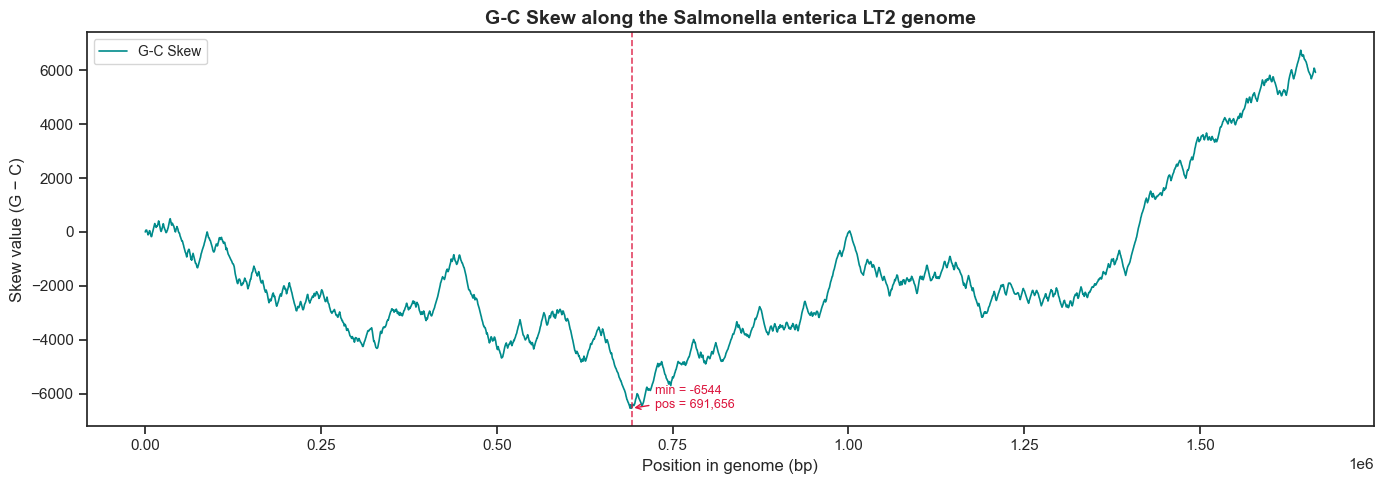

Minimum skew value  : -6544
Minimum position(s) : ['691,656', '691,657', '691,658', '691,659', '691,660', '691,661', '691,662', '691,663', '691,664', '691,665', '691,666', '691,667', '691,670', '691,671', '691,672', '691,673', '691,674', '691,675', '691,676', '691,678', '691,679', '691,680', '691,681', '691,682', '691,683', '691,684', '691,685', '691,686', '691,687', '691,688', '691,689', '691,690']


In [4]:
min_positions, min_value = plot_gc_skew(
    sequence = str(genome_seq.seq).upper(),
    title    = "G-C Skew along the Salmonella enterica LT2 genome",
)

The skew diagram reveals a global minimum at position **691,656**, which we take as the center of one of the possible multiple candidates of oriC regions. Still the diagram looks far from the ideal G-C Skew diagram with well defined minimums. We will now start analizing this region, extracting a subsequence around this position to search for ORBs (Origin Recognition Box) and try to find information that may (or not) reappear in other oriC regions.

## 3.2 Frequent k-mers with mismatches in the candidate oriC region

We apply `frequent_patterns_with_mismatches` to a candidate region based on the previous step.
We use k=9, consistent with the known length of DnaA boxes in closely related organisms, and allow
d=1 mismatch to account for degeneracy in the binding motif.

To explore the potential ori region, lets analyze 1000 bp around the skew minimum.

In [5]:
# Define the potential oriC region
window    = 1000
subseq_start = max(0, min_positions[0] - window)
subseq_end   = min(len(genome_seq), min_positions[0] + window)
potential_ori_region = str(genome_seq[subseq_start : subseq_end].seq)

In [6]:
k = 9
d = 1
n = 30

results = frequent_patterns_with_mismatches(potential_ori_region, k, d, n)

print(f"{'k-mer':<12} {'total':>6} {'fwd':>6} {'rc':>6}")
print("-" * 34)
for kmer, total, fwd, rc in results:
    print(f"{kmer:<12} {total:>6} {fwd:>6} {rc:>6}")

k-mer         total    fwd     rc
----------------------------------
AACACGATC         7      2      5
AAGATCTTC         7      4      3
AAAAAGATC         6      3      3
AGATCTTCA         6      4      2
CCAGGATCC         6      3      3
CCGGGATCC         6      3      3
CGCACCGCG         6      2      4
CTGATTATC         6      3      3
GATCCCGGC         6      3      3
TGTGGATAA         6      4      2
AAAAAAGTG         5      3      2
AAAAAGAGA         5      1      4
AAAACCGAT         5      3      2
AAAACGATC         5      2      3
AAAACTGAA         5      4      1
AAAATCTGG         5      1      4
AAACCGATC         5      1      4
AAAGATCCT         5      3      2
AACCAGATC         5      2      3
AACGCGCTG         5      3      2
AAGACGATC         5      3      2
AATCGATCG         5      2      3
AATCTGTTG         5      2      3
ACAGGATCC         5      2      3
ACCAGATCT         5      3      2
ACCGCCGGG         5      3      2
ACCGCGGTA         5      2      3
ACGGCGCCG    

Inspecting the results by eye, three groups of k-mers emerge:

- **GATC-containing motifs**: highly frequent due to Dam methylation sites, which are known
  to concentrate in oriC regions of gram-negative bacteria.

- **A-T rich motifs**: consistent with the well-documented AT bias of replication origin
  regions, which facilitates DNA strand separation during replication initiation.

- **A third group** of motifs that do not fall into either category above, with relatively
  high frequency. These are our candidates for DnaA boxes.

To distinguish true DnaA boxes from statistical noise, we need to verify that these
candidate motifs are not just frequent, but also spatially clustered, appearing multiple
times within a shorter window. This is what we test in the next section.

## 3.3 Clump finding — verifying spatial clustering

A true DnaA box motif should appear clustered within a short stretch of the oriC region. We use `find_clumps` with the following parameters:

- **k = 9**: same as above
- **L = 300**: window size consistent with the expected length of oriC in Salmonella (~245 bp in E. coli)
- **t = 4**: minimum number of occurrences within the window
- **d = 1**: one mismatch allowed
- **use_rc = True**: reverse complement occurrences are counted, since DnaA binds double-stranded DNA

In [7]:
k = 9
L = 300
t = 4
d = 1
use_rc = True

clumps = find_clumps(potential_ori_region, k, L, t, d, use_rc)
clumps_clean = clean_clump_noise(clumps)

print(f"Total clumps found: {len(clumps_clean)}\n")
print(f"{'k-mer':<12} {'first pos':>10} {'exact':>7} {'variants':>9}")
print("-" * 42)
for kmer, pos, exact, variants in clumps_clean:
    print(f"{kmer:<12} {pos:>10} {exact:>7} {variants:>9}")

Total clumps found: 23

k-mer         first pos   exact  variants
------------------------------------------
ACCGCCGGG           100       0         4
CCCGGCGGT           100       0         4
TAGGATCCT           171       0         4
GATCTTTTT           402       1         3
GATCCTTAT           402       0         4
ATAAGGATC           402       0         4
AAAAAGATC           402       0         4
AGGATCCTG           404       1         3
CGGGATCCT           405       0         4
CCAGGATCC           406       0         4
GGATCCTGG           406       0         4
CCGGATCCG           509       0         4
CGGATCCGG           509       0         4
AGATCTCTT           532       0         4
AAGAGATCT           532       0         4
AAAAGATCA           532       0         4
TGATCTTTT           532       0         4
TAAAGATCT           532       0         4
AGATCTTTA           532       0         4
TGTGGATAA           590       1         3
TTATCCACA           590       1         3
TTCCGGAAT

Still, a lot of GATC-containing motifs and different DnaA box candidates.

Let's narrow down the clump length changing L from 300 to 200.

In [8]:
t = 4
L = 200
clumps = find_clumps(potential_ori_region, k, L, t, d, use_rc)
clumps_clean = clean_clump_noise(clumps)

print(f"Total clumps found: {len(clumps_clean)}\n")
print(f"{'k-mer':<12} {'first pos':>10} {'exact':>7} {'variants':>9}")
print("-" * 42)
for kmer, pos, exact, variants in clumps_clean:
    print(f"{kmer:<12} {pos:>10} {exact:>7} {variants:>9}")

Total clumps found: 12

k-mer         first pos   exact  variants
------------------------------------------
ACCGCCGGG           100       0         4
CCCGGCGGT           100       0         4
CCAGGATCC           508       0         4
GGATCCTGG           508       0         4
CCGGATCCG           509       0         4
CGGATCCGG           509       0         4
AGATCTCTT           532       0         4
AAGAGATCT           532       0         4
AAAAGATCA           532       0         4
TGATCTTTT           532       0         4
TGTGGATAA           590       1         3
TTATCCACA           590       1         3


Once again, GATC-containing motifs dominate the results. Two other candidate pairs emerge:

- `CCCGGCGGT` / `ACCGCCGGG`

- `TGTGGATAA` / `TTATCCACA`

The key difference between them lies in their exact occurrence counts. Both strands of `CCCGGCGGT` / `ACCGCCGGG` have no exact matches, they never appear literally in the sequence, existing only as mismatch variants of other k-mers. This suggests they are statistical noise introduced by the d=1 neighborhood expansion.
In contrast, `TGTGGATAA` / `TTATCCACA` shows exact occurrences on both strands independently, consistent with a real binding motif present on the double-stranded DNA. This is our strongest candidate for the DnaA box consensus sequence in Salmonella enterica LT2. This result is further supported by the fact that `TTATCCACA` is the experimentally validated DnaA box consensus sequence of *E. coli*, a closely related organism.

Now a visualization that allows us to verify at a glance that the DnaA box candidates are not randomly distributed across the region, but concentrated around the skew minimum, 
consistent with the expected structure of a replication origin.

In [9]:
highlight_sequence_html(
    sequence = potential_ori_region,
    patterns = [
        ("TTATCCACA", 1),
        ("TGTGGATAA", 1),
        ("CCCGGCGGT", 1),
        ("ACCGCCGGG", 1),
        ("GATC", 0),
    ],
    colors  = ["#86efac", "#86efac", "#dc4626", "#dc4626", "#fdba74"],
    offset  = subseq_start,
    markers = [(min_positions[0], "skew minimum", "#dc2626")],
    line_width = 90,
    font_size = 18
)

## 7. Conclusion

Starting from the full genome of *Salmonella enterica* LT2 (NC_003197.2), we:

1. Located the candidate oriC region using G-C skew minimization.
2. Identified the most frequent 9-mers with up to 1 mismatch in that region.
3. Verified spatial clustering of the top candidates using clump finding.

This computational approach with the help of some theory knowledge, based on probability of sequence reappearences,
can converge on a small set of candidate motifs for the DnaA boxes of *Salmonella enterica* LT2.